In [3]:
# import general packages
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.animation import FFMpegWriter
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec

from scipy.interpolate import interp1d
from scipy.optimize import brentq

import h5py
import json
import os
from datetime import datetime

import pde
import phasesep_pyrenoid as ph
from phasesep_pyrenoid.helper_functions import dimensionalize_params, get_initial_radius, cmap_exp, cmap_orange, dark_orange, colors, colors_exp, colors_phases, scale_length, dt_length, add_scalebar, add_timenote
from phasesep_pyrenoid.solvers_simulations import solve_stokes_flow, run_simulation
from droplets import DiffuseDroplet, Emulsion, SphericalDroplet

radius_micrometer = 1 # [micro meter]
shrinking_time = 10 # [minutes]

FOLDER_RESULTS = "./simulation_results/Paper/"
FOLDER_FIGURES= FOLDER_RESULTS+"figures_for_paper/"

This code produces the behaviour of pyrenoid dissolution, deformation, puncta formation and fission for Fig 3, and creates characteristic timescales, spatial scale and pressure scale to convert from dimensionless to dimensional parameters

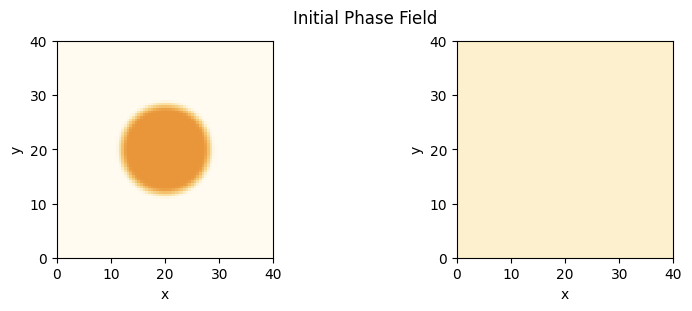

100%|██████████| 100.0/100.0 [00:53<00:00,  1.87it/s]   
100%|██████████| 101/101 [00:05<00:00, 17.84it/s]


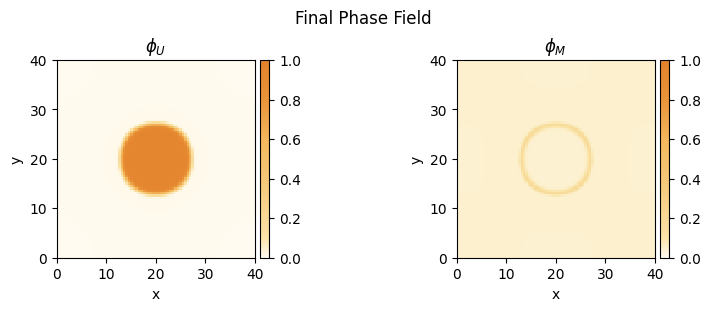

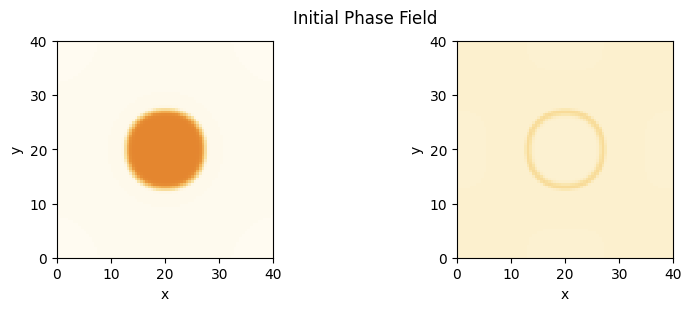

100%|██████████| 100.0/100.0 [00:50<00:00,  1.99it/s]    
100%|██████████| 101/101 [00:05<00:00, 17.74it/s]


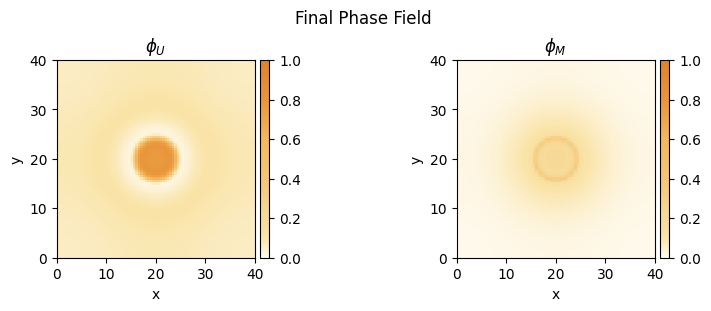

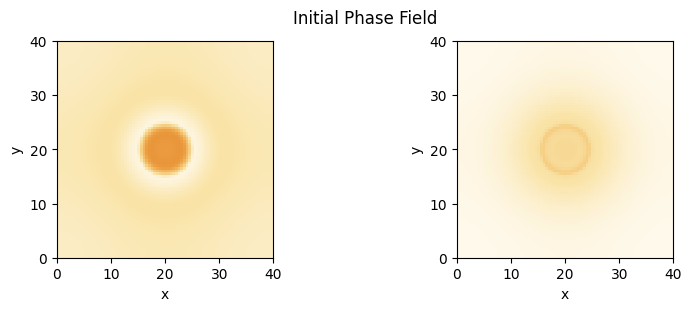

  0%|          | 0/150.0 [00:00<?, ?it/s]              

dimx, dimy 81 81


100%|██████████| 150.0/150.0 [02:09<00:00,  1.16it/s]    
100%|██████████| 151/151 [00:08<00:00, 17.57it/s]


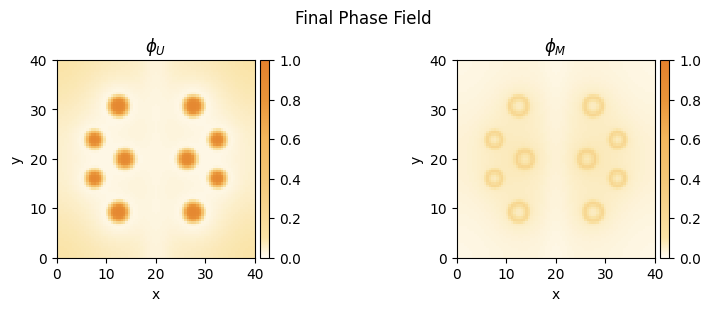

In [7]:
num_phases = 3
chem_reacts = [False, True, True]
km_reacts = [0, 0.03, 0.03]
chem_reacts_types = ["None", "ext_maint", "ext_maint"]
start_from_input_files = [False, True, True]
advec = [False, False, True]
sim_times = [100,100,150]
input_filename_vec = []

for phase in range(num_phases):
    params_advection = {
        "nx": 83,
        "ny": 83,
        "Lx": 40.0,
        "Ly": 40.0,
        "mu": 40,
        "eta": 12.5,
        "P0": 10,
        "sigma_P": 1.2
    }

    chem_react = chem_reacts[phase]
    params = {
        "k_M": km_reacts[phase] if chem_react else 0,
        "k_U": 0.03 if chem_react else 0,
        "chem_react_type": chem_reacts_types[phase] if chem_react else "None",
        "xc" : 0.5,
        "b" : 200,
        "d" : 1, #9.6 
        "kappa": 1,
        "chi" : 5, # Positive = repulsion
        "shape" : 40,
        "size" : 81,
        "simulation_time" : sim_times[phase],
        "periodic_bc" : False,
        "interval_for_tracking" : 1,
        "advection": advec[phase]
    }

    start_from_input_file = start_from_input_files[phase]
    input_folder = input_filename_vec[phase-1] if start_from_input_file else None
    input_filename = input_folder+"final_config" if start_from_input_file else None #"asym_eq_config_no_chem_react" #f"phase2_asym__chem_react_kM_0.05_kU_0.05_simT_30"#"eq_config_no_chem_react"#f"Upot3_chem_react_kM_0.05_kU_0.05_simT_100"#"eq_config_no_chem_react"#f"Upot_chem_react_kM_0.05_kU_0.05_simT_{simulation_time}"#"eq_config_no_chem_react" #"phase_1_off_chem_react_kM_0.05_kU_0.05_simT_150" #"eq_config_no_chem_react" 

    # Choose initial conditions for U and M
    selected_init_cond_U = "from_file" if start_from_input_file else "single_droplet"  # Change this to "random" or "emulsion" or "single_droplet" or "start_from_input_file"
    selected_init_cond_M = "from_file" if start_from_input_file else "random"  # Can be different from U

    # Define parameters separately for U and M
    PARAMS_INIT_U = {
        "from_file":{ "filename": input_filename,
            "suffix": "_U.hdf5"
        },
        "random": {
            "phi": 0.5,
            "std": 2e-4
        },
        "single_droplet": {
            "phi_out": 0.0001,
            "phi_in": 0.8,
            "radius": 8,
            "position": [20, 20]  # Relative to shape center
        },
        "emulsion": {
            "phi": 0.5,
            "droplets": [
                {"position": [1/3, 1/3], "radius": 8},
                {"position": [1/3 + 8.2, 1/3 + 8.2], "radius": 3}
            ]
        }
    }

    PARAMS_INIT_M = {
            "from_file":{ "filename": input_filename,
            "suffix": "_M.hdf5",
        },
        "random": {
            "phi": 0.05,
            "std": 2e-4
        },
        "single_droplet": {
            "phi_out": 0.0001,
            "phi_in": 0.8,
            "radius": 8,
            "position": [25, 25]  # Relative to shape center
        },
        "emulsion": {
            "phi_out": 0.0001,
            "phi_in": 0.8,
            "droplets": [
                {"position": [1/3, 1/3], "radius": 7.5},
                {"position": [1/3 + 8.2, 1/3 + 8.2], "radius": 2.5}
            ]
        }
    }


    save_final_config = True
    ### Save params ###
    if save_final_config:
        run_name = f"{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
        output_folder = f"simulation_results/Paper/definite/{run_name}/"
        input_filename_vec.append(output_folder)
        os.makedirs(output_folder, exist_ok=True)

        with open(f"{output_folder}/params.json", "w") as f:
            json.dump(params, f, indent=4)
        if params["advection"]:
            with open(f"{output_folder}/params_advection.json", "w") as f:
                json.dump(params_advection, f, indent=4)
    output_filename = output_folder+f"final_config"

    P, u, x, y, X, Y = solve_stokes_flow(**params_advection)

    sol, solver_info = run_simulation(selected_init_cond_U,
        selected_init_cond_M,
        PARAMS_INIT_U[selected_init_cond_U],
        PARAMS_INIT_M[selected_init_cond_M],
        save_final_config, input_filename, output_filename, output_folder, chem_react, u = u, cmapcolor = cmap_orange, **params)


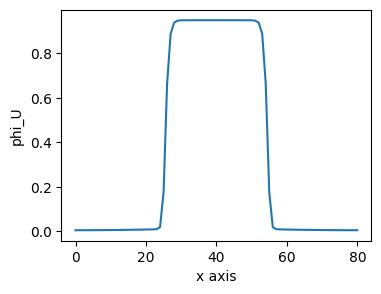

In [46]:
parent_folder_phase0 = FOLDER_RESULTS + "definite/2025-09-22_11-32-48/"
parent_folder_phase1 = FOLDER_RESULTS + "definite/2025-09-22_11-33-48/"
parent_folder_phase2 = FOLDER_RESULTS+ "definite/2025-09-22_11-34-44/"

radius = get_initial_radius(parent_folder_phase0)
L_char = radius_micrometer / radius # Because I want the initial droplet to have 1 micro meter radius, so  radius * L_char = 1 micro meter

# Read from file
with open(parent_folder_phase1 + "params.json", "r") as f:
    params_1 = json.load(f)

T_char = shrinking_time / params_1["simulation_time"] # Because I want the shrink to occur in 10 min, so t_tot * T_char = 10 min

with open(parent_folder_phase2 + "params.json", "r") as f:
    params_2 = json.load(f)
with open(parent_folder_phase2 + "params_advection.json", "r") as f:
    params_advec_2 = json.load(f)

# Water has viscosity = 1mPa * s
water_viscosity = 1 # mPa * s
water_viscosity_pa_min = 1 * 0.001 / 60 # Pa * min
stroma_viscosity_pa_min = 10 * water_viscosity_pa_min

P_char = stroma_viscosity_pa_min / (params_advec_2["mu"] * T_char)

params_dim_2, params_advec_dim_2 = dimensionalize_params(params_2, params_advec_2, L_char = L_char, T_char = T_char, P_char = P_char)

charact_scales = {"T_char": T_char,
                  "L_char": L_char,
                  "P_char": P_char}

with open(f"{FOLDER_RESULTS}definite/charact_scales.json", "w") as f:
            json.dump(charact_scales, f, indent=4)


In [44]:
params_2

{'k_M': 0.03,
 'k_U': 0.03,
 'chem_react_type': 'ext_maint',
 'xc': 0.5,
 'b': 200,
 'd': 1,
 'kappa': 1,
 'chi': 5,
 'shape': 40,
 'size': 81,
 'simulation_time': 150,
 'periodic_bc': False,
 'interval_for_tracking': 1,
 'advection': True}

In [42]:
params_dim_2

{'k_M': 0.3,
 'k_U': 0.3,
 'chem_react_type': 'ext_maint',
 'xc': 0.5,
 'b': 200,
 'd': np.float64(0.2040816326530612),
 'kappa': np.float64(0.14285714285714285),
 'chi': 5,
 'shape': np.float64(5.7142857142857135),
 'size': 81,
 'simulation_time': 15.0,
 'periodic_bc': False,
 'interval_for_tracking': 1,
 'advection': True}

In [19]:
params_advec_dim_2

{'nx': 83,
 'ny': 83,
 'Lx': np.float64(5.7142857142857135),
 'Ly': np.float64(5.7142857142857135),
 'mu': 0.00016666666666666672,
 'eta': np.float64(0.002552083333333334),
 'P0': 0.00041666666666666675,
 'sigma_P': 5e-05}

In [45]:
params_advec_2

{'nx': 83,
 'ny': 83,
 'Lx': 40.0,
 'Ly': 40.0,
 'mu': 40,
 'eta': 12.5,
 'P0': 10,
 'sigma_P': 1.2}

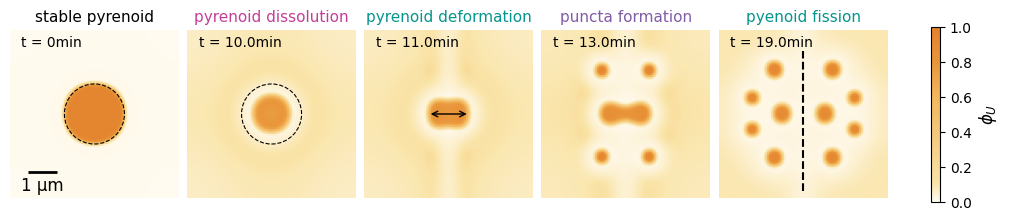

In [59]:
titles = ["stable pyrenoid", "pyrenoid dissolution", "pyrenoid deformation", "puncta formation", "pyenoid fission"]
# Load data
storage_read1 = pde.FileStorage(parent_folder_phase1+"final_config.hdf")
times = [0]

# Set up figure and axes
fig, axs = plt.subplots(1, 5, figsize=(10, 3), constrained_layout=True)
dx = params_1["shape"] / (params_1["size"]-1)
# Plot each time point
for i, time in enumerate(times):
    UM_fields = storage_read1[time]
    data = np.transpose(UM_fields.data[0])
    im = axs[0].imshow(data, cmap=cmap_orange, vmin=0, vmax=1, origin="lower")
    axs[0].axis('off')
    add_scalebar(axs[0], scalebar_length = 1/(L_char*dx))
    add_timenote(axs[0], time,)
axs[0].set_title(titles[0], fontsize=11, color = "black")

# Load data
storage_read2 = pde.FileStorage(parent_folder_phase2+"final_config.hdf")
times = [0, 10, 30, 90]

t0 = params_1["simulation_time"]

# Plot each time point
for i, time in enumerate(times):
    UM_fields = storage_read2[time]
    data = np.transpose(UM_fields.data[0])
    im = axs[i+1].imshow(data, cmap=cmap_orange, vmin=0, vmax=1, origin="lower")
    #axs[i].set_title(f"t={int(time)}")
    axs[i+1].axis('off')
    add_timenote(axs[i+1], (time+t0)*T_char,)
    if i<3:
        axs[i+1].set_title(titles[i+1], fontsize=11, color = colors_phases[i])
    else:
        axs[i+1].set_title(titles[i+1], fontsize=11, color = colors_phases[1])

cbar = fig.colorbar(im, ax=axs.ravel().tolist(), shrink=0.6, orientation='vertical')
center = 40
circle1 = patches.Circle((center, center), radius=scale_length, edgecolor='black', facecolor='none', linestyle = "--", linewidth=0.8)
circle2 = patches.Circle((center, center), radius=scale_length, edgecolor='black', facecolor='none', linestyle = "--", linewidth=0.8)
axs[1].add_patch(circle1)
axs[0].add_patch(circle2)

arrow = patches.FancyArrowPatch((30, center), (50, center), arrowstyle='<->', 
                        color='black', linewidth=1, mutation_scale=10)

axs[2].add_patch(arrow)
axs[4].vlines(center, 3,70, linestyle = "--", color ="black")
cbar.set_label(r"$\phi_U$", fontsize=12)
plt.savefig(FOLDER_FIGURES+"Ru_concentration_snapshots.svg")
plt.show()


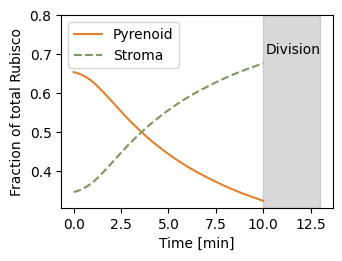

In [55]:
# Plot total fluorescence in pyrenoid and outside over time
pyrenoid_init_mask = np.transpose(storage_read1[0].data[0])>params_1["xc"]
UM_fields = storage_read1[0]
data = np.transpose(UM_fields.data[0]+UM_fields.data[1])
tot_abundance_UM = np.sum(data)
tot_conc_in = []
tot_conc_out = []
tot_time = params_1["simulation_time"]
times = np.linspace(0,tot_time,tot_time)
for i, time in enumerate(times):
    UM_fields = storage_read1[i]
    data = np.transpose(UM_fields.data[0]+UM_fields.data[1])
    tot_conc_in.append(np.sum(data*(pyrenoid_init_mask)))
    tot_conc_out.append(np.sum(data*(1-pyrenoid_init_mask)))
tot_conc_in = np.array(tot_conc_in)
tot_conc_out = np.array(tot_conc_out)

fig, ax = plt.subplots(figsize=(3.5,2.5))
plt.plot(times * T_char, tot_conc_in/tot_abundance_UM, label = "Pyrenoid", color = dark_orange)
plt.plot(times * T_char, tot_conc_out/tot_abundance_UM, label = "Stroma", linestyle = "--", color = "#7B9958")
ax.axvspan(tot_time * T_char, (tot_time+0.3*tot_time)* T_char, color='gray', alpha=0.3)
plt.legend(loc = "best")
plt.text((tot_time+1)* T_char, 0.7, 'Division', fontsize=10, color='black')
plt.xlabel("Time [min]")
plt.ylabel("Fraction of total Rubisco")
plt.ylim(top = 0.8)

plt.savefig(FOLDER_FIGURES+"stroma_pyrenoid_fractions_over_time.svg", bbox_inches = "tight")
plt.show()